In [ ]:
### File Originally Created By Bipul Pandey on 9th Feb 2024

### Python Version - 3.9.12
### Scipy Version - 1.7.3
### Matplotlib Version -  3.5.1 
### Scikit-learn Version - 1.0.2
### numpy Version -  1.21.6 
### Pandas Version - 1.4.2

## This notebook contains the following:
    #   1) Principal Component Analysis 
    #   2)Visualization of Metabolite vs KP Suppression landscape

## The relevant dataset is the raw dataset containing measurements of Metabolite Z scores at 120 hours and KP CFU

## Name of the Dataset : "Metabolite_120_Hr_dataset.csv"


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.interpolate import griddata
import scipy.signal as spsg

#### Now onward to PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from mpl_toolkits.mplot3d import Axes3D

___
### A. Reading the Dataset and Partitioning it into relevant data and labels:

- We first read the file containing the metabolite Z-scores as well as the KP loads at the end of 120 hours. This data is in the file with the following name   - $\text{Metabolite\_120\_Hr\_dataset.csv}$.

- This file can be found in the "$\text{Datasets}$" folder.

- We then create separate arrays containing the respective community names, metabolite names, KP loads as well as the metabolite concentration matrix. 

- Small Regularization of KP CFU is necessary since we will be dealing with log of KP CFU (and Log(0) is undefined). 
_____

In [5]:
### First we Import the Relevant Dataset
### In this case it is the original 81 experiments
### 15/96 experiments have metabolitead panels of metabolite missing
## Therefore inorder to preserve the quality of dataset, we chose to remove those rather than fill missing panels with 0


Dataset_name = "../Datasets/Metabolite_120_Hr_dataset.csv"

Metabolite_Dataframe = pd.read_csv(Dataset_name)

## Now we separate the relevant parts of the data.
### This will be the - names of the experiments,
###                  - KP CFU (Klebsiella pneumoniae Colony Forming Units)
##                   - The Names of the Metabolites 
##                   - The Metabolite Z scores  
Experiment_names = np.array(Metabolite_Dataframe["Community"])
KP_CFU = np.array(Metabolite_Dataframe["KP_CFUs"])
Metabolites = np.array(Metabolite_Dataframe.columns[1:-1])
Metabolite_matrix = np.array(Metabolite_Dataframe[Metabolites])


# We will deal with Log_10 of KP CFU since all we care about is the order of magbnitude supression
# But we will need to regularize this dataset since there are entries with 0.
regularizer = 1
Log10_KP_CFU  = np.log10(KP_CFU + regularizer)

_____
_____
### B. Principal Component Analysis:

### B.a. Data Clean Up: 

For the PCA, we first need to mean-center and normalize the data. This means the following:
- We need to subtract the column wise mean of this data
- Then we need to normalize this data.
- As in column sum after normalization = 0
- Mean subtracted, normalized matrix is as follows:



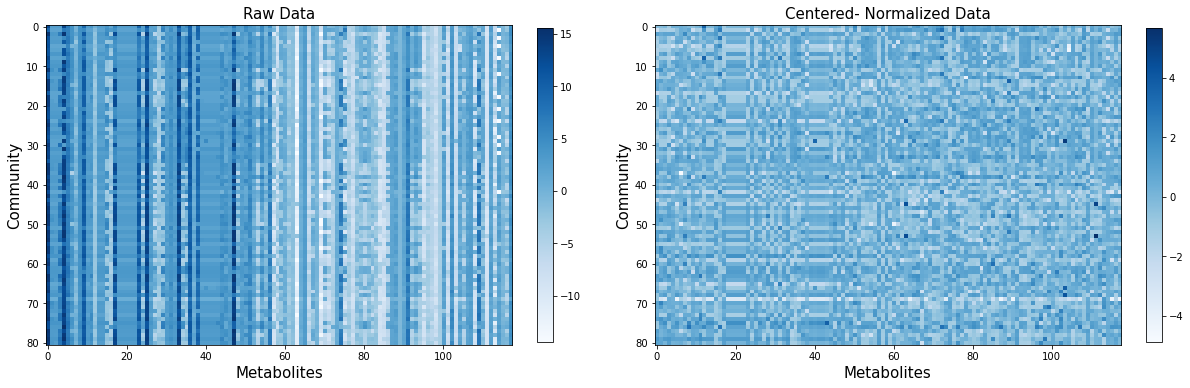

In [6]:
#### ------------ Data Clean Up ------------
# We need to subtract the column wise mean of this data
# Then we need to normalize this data.
# As in column sum after normalization = 0
# Mean subtracted, normalized matrix is as follows:

Normalized_matrix = StandardScaler().fit_transform(Metabolite_matrix)
### Visualization of the original Matrix as well as the normalized centered matrix
fig, ax = plt.subplots(1,2, figsize = (20,10))
z1 = ax[1].imshow(Normalized_matrix, cmap = "Blues")
z2 = ax[0].imshow(Metabolite_matrix, cmap = "Blues")
plt.colorbar(z1, ax=ax[1], fraction = 0.031)
plt.colorbar(z2, ax = ax[0], fraction = 0.031)
ax[0].set_title("Raw Data", fontsize = 15)
ax[1].set_title("Centered- Normalized Data", fontsize = 15)
ax[0].set_ylabel("Community", fontsize = 15)
ax[1].set_ylabel("Community", fontsize = 15)

ax[0].set_xlabel("Metabolites", fontsize = 15)
ax[1].set_xlabel("Metabolites", fontsize = 15)
plt.show()

____
#### B.b.  PCA Calculation:
    There are 118 metabolite features and 81 communities in the datamatrix. 
    In Principal, we can have min(118,81)=81 components in the PCA.  The contributions of high PCs are too small. Hence, we set the N_components to 50.

In [17]:
##3 Performing PCA

N_components=50

pca_function = PCA(n_components=N_components)

pc_names =["PC"+str(i) for i in range(1, N_components+1)]

principalComponents_total = pca_function.fit_transform(Normalized_matrix)

PComp_total_DF = pd.DataFrame(data = principalComponents_total, columns = pc_names)

____
#### B.c. Information content of each PC:
We can visualize the information content in each PC  as well as the growth of cumulative information with each additional PC.
This is given by the explained variance of any PC. Here we report these values in percentage.

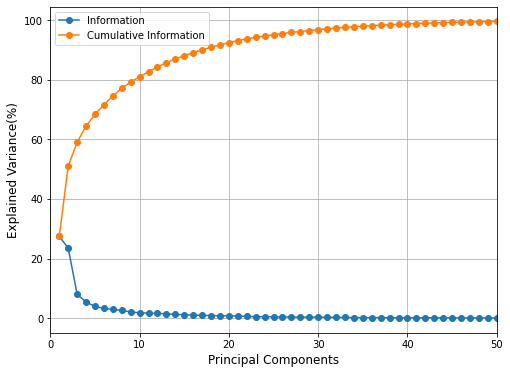

In [18]:
Information_content = np.array(pca_function.explained_variance_ratio_)*100
Cumulative_Information = np.cumsum(Information_content)

plt.figure(figsize=(8,6))
plt.plot(np.arange(1,N_components+1), Information_content, "o-", label = "Information")
plt.plot(np.arange(1,N_components+1), Cumulative_Information, "o-", label = "Cumulative Information")
plt.ylabel("Explained Variance(%)", fontsize = 12)
plt.xlabel("Principal Components", fontsize = 12)
plt.legend()
plt.grid()
plt.xlim(0,N_components)
plt.show()

#### B.d. Projection of the data to the first two Principal Components and visualization: 

In [19]:
Comp1 = "PC1"
Comp2 = "PC2"


X_coord = list(PComp_total_DF[Comp1])
Y_coord = list(PComp_total_DF[Comp2])
Coordinates = list(zip(X_coord,Y_coord))


Regularizer = 1

Point_array = np.zeros((len(X_coord), 2))
Point_array[:,0] = X_coord
Point_array[:,1] = Y_coord


Values = Log10_KP_CFU
#The "Values_suppression" gives the order of magnitude supression of KP from baseline
Values_suppression = np.max(Values) - Values 


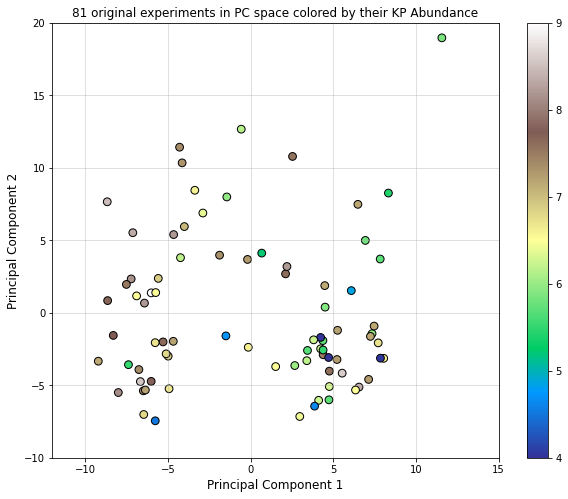

In [24]:
Vmax = 9   ## <= Maximum possible KP CFU. This is when KP is grown alone"

Vmin = 4  ## <= Anything below KP CFU= 10^4  is same color"

plt.figure(figsize=(10,8))
plt.scatter(X_coord,Y_coord ,c = Values, vmax=Vmax, vmin =Vmin,cmap = "terrain", edgecolors="black", s=60)
plt.colorbar()
plt.xlabel("Principal Component 1", fontsize = 12)
plt.ylabel("Principal Component 2", fontsize = 12)
plt.title("81 original experiments in PC space colored by their KP Abundance")
plt.grid( alpha = 0.5)
plt.xlim(-12,15)
plt.ylim(-10,20)
plt.show()

______
#### B.e. Saving the Principal Component Analysis information about the communities:

In [20]:
## Saving the Principal component information about communities

Dataset =np.array([Experiment_names,X_coord, Y_coord, Values]).T
Metabolite_PCA_array = pd.DataFrame(Dataset, columns= ["Community","PC-1", "PC-2", "Log10(KP-CFU)"])
Metabolite_PCA_array.to_csv("../Datasets/PCA_coordinates_Metabolite_Space_Original_81.csv", sep = ",")


_____
_____
### C. Construction of the surface plots for the Metabolite landscape in PC-1 /PC-2 space:

The steps are as follows:

- X and Y axes are PC-1 and PC-2 axes. Z axis is for the KP suppression. ("Blues" imply larger KP suppression, "Whites" imply low or no KP suppression)
- Construct a meshgrid large enought to capture all the experiments visualized in PC-1, PC-2 space. (Refer to section B.d.) ( x_low, x_high, y_low, y_high are the X and Y bounds)
- num_points controls the resolution of the meshgrid. The higher this value, the better resolution of plots. (But rendering becomes slower)
- grid_x, grid_y contain the X and Y coordinates of all the points in the grid.
- grid_z1 contains the linear interpolation supression values for all points in the meshgrid.


In [30]:
### Generating the Surface plots

### The X-Y grid for plotting the landscape:
x_low = -20
x_high = 20
y_low = -20
y_high = 20
num_points = 1000   #<= Increase this for higher resolution surfaces. But slow render

grid_x, grid_y = np.meshgrid(np.linspace(x_low, x_high, num_points),np.linspace(y_low, y_high, num_points), indexing='ij')

#We will linearly interpolate between the points

grid_z1 = griddata(Point_array, Values_suppression, (grid_x, grid_y), method='linear')

_____
______
#### D. Plotting this meshgrid heatmap. 

We can visualize this heatmap or landscape in two ways.
    
    - 2D aerial view.
    - 3D hillside view.




### 2D Aerial View:

Parameter:
'$\text{v\_max}$' 

It is the parameter that controls what is the cutoff for the color scheme. Any value beyond this is of the same color.

In our case, if $\text{v\_max} = 5$ , that means KP suppression by of 5 orders of magnitude or lower (i.e $log_{10}[\text{KP CFU}]\leq 4$) will be of same color (Deep Blue).
This information is also reflected in the colorbars

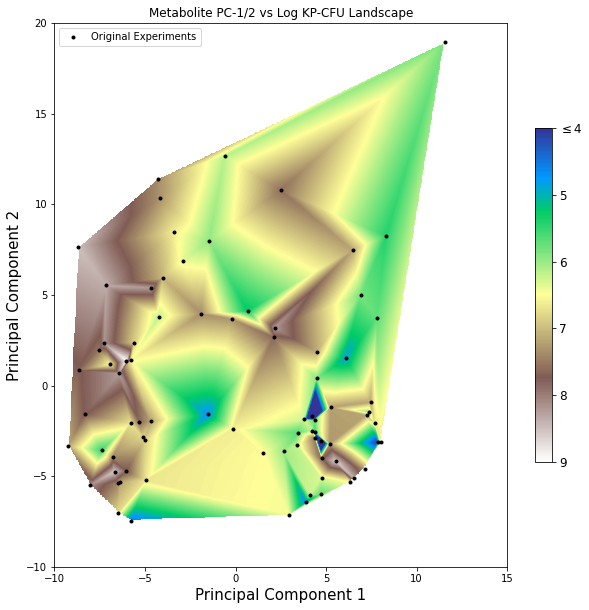

In [31]:
### Plotting Metabolite vs KP Supression 
v_max = 5
### Here we have shifted the color bar from Order of magnitude Supression to order of magnitude KP

plt.figure(figsize=(10,10))
plt.imshow(grid_z1.T, extent=(x_low,x_high,y_low,y_high), origin='lower', vmax=5 ,cmap = "terrain_r")
#plt.imshow(grid_z1.T, extent=(-20,20,-20,20), origin='lower', cmap = "terrain_r")
plt.plot(Point_array[:, 0], Point_array[:, 1], 'ko', ms=3, label = "Original Experiments")
plt.xlim(-10,15)
plt.ylim(-10,y_high)
cb = plt.colorbar( fraction = 0.03)
cb.set_ticks(range(0,6))
cb.ax.set_yticklabels([9,8,7,6,5,r'$\leq 4$'], fontsize = 12)
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize =15)
plt.title(r"Metabolite PC-1/2 vs Log KP-CFU Landscape")
plt.legend()
plt.show()

#### 3D Hillside View:


The 3D hillside view requires additional parameters along with 'v_max' for the camera setup and resolution. These are 

    - elev = elevation angle
    - azim = azimuthal angle
    - stride = Quality of rendering the meshgrid.


We have additionally included the shadow of the landscape for the ease of visualization. 

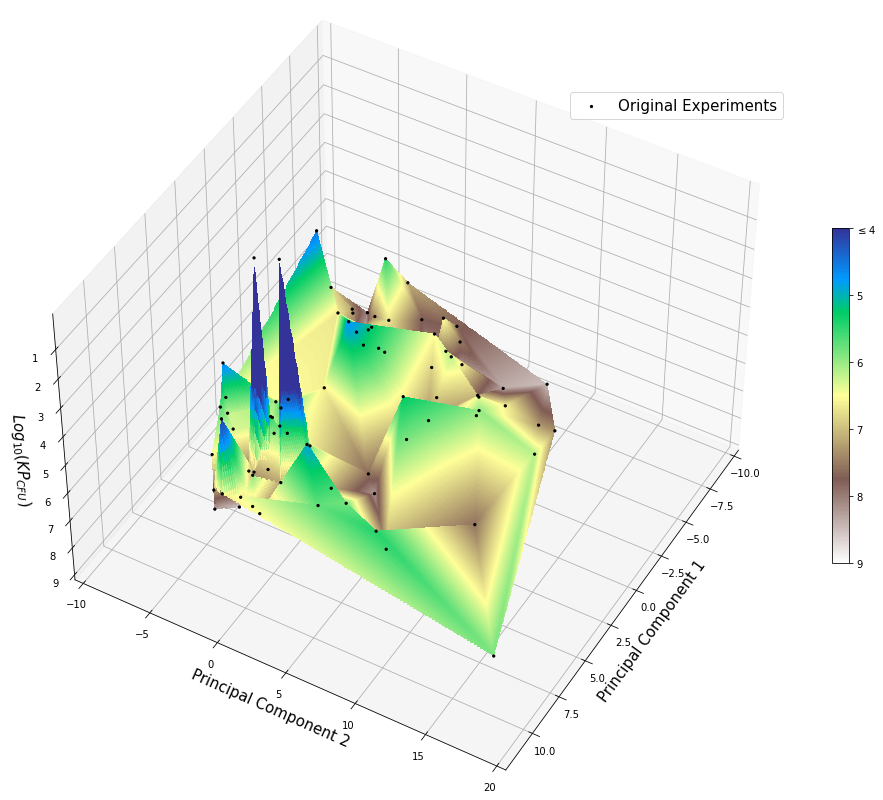

In [39]:
### We will now visualize this heatmap in 3 dimensions using mpl_toolkits (3D hillside view)

### Camera angle parameter
elev = 45
azim = 30
stride = 1

## Colour parameter
kolor = 'terrain_r'
#kolor = "coolwarm"



fig1 = plt.figure( figsize=(15,15))
ax1 = fig1.add_subplot(projection='3d')

### the scatter plot of original experiments
ax1.scatter3D(Point_array[:,0], Point_array[:,1], Values_suppression, color = "black", alpha = 1, s = 5, zorder = 1, marker = "o",label = "Original Experiments")

## The contour plot in 2D to visualize the floor better - makes it easy to visualize the heights
#cset = ax1.contourf(grid_x, grid_y,grid_z1, zdir='z', vmin = 0, vmax=v_max,offset=0, cmap=kolor, alpha = 0.3, zorder = 0)


### The actual 3D surface
surf = ax1.plot_surface(grid_x,grid_y,grid_z1,cmap = kolor,vmax = v_max,vmin = 0, zorder = 3,antialiased=False, alpha = 1, rstride = stride, cstride = stride)
cb= plt.colorbar(surf, ax = ax1, fraction = 0.02)
cb.set_ticks(range(0,6))
cb.ax.set_yticklabels([9,8,7,6,5,r'$\leq 4$'])

ax1.view_init(elev, azim)
ax1.set_xlim(-10,12)
ax1.set_ylim(-10,20)
ax1.set_zlim(0,9)
ax1.set_xlabel("Principal Component 1", fontsize = 15)
ax1.set_ylabel("Principal Component 2", fontsize = 15)
ax1.set_zlabel(r"${Log}_{10}(KP_{CFU})$",fontsize = 15)
ax1.xaxis.label.set_rotation(0)
ax1.set_zticks(range(0,9), range(9,0, -1))
plt.legend(bbox_to_anchor=(0.5, 0.4, 0.5, 0.5), fontsize = 15)

plt.show()